In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import stattools as stt
from statsmodels import tsa
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings

warnings.filterwarnings("ignore")

def is_stationary(df, maxlag=52, autolag=None, regression='ct'):
    adf_test = stt.adfuller(df.values,maxlag=maxlag, autolag=autolag, regression=regression)
#     print(adf_test)
    adf = adf_test[0]
    cv_5 = adf_test[4]["5%"]
    result = adf < cv_5
#     print(adf, '--', cv_5, result)
    return result


def d_param(df, max_lag=52):
    d = 0
    if ~is_stationary(df):
        for i in range(1, max_lag):
            if is_stationary(df.diff(i).dropna()):
                d = i
                break;
    return d

def ARMA_params(df):
    p, q = tsa.stattools.arma_order_select_ic(np.asarray(df.dropna()), max_ar=4, max_ma=2, ic='aic', trend='c').aic_min_order
    
    return p, q


# filePath = "Datasets/DS_MA2_aafe.csv"
filePath = "Datasets/DS_MA2_asdw.csv"


csvFile = pd.read_csv(filePath)
print(csvFile)

     Unnamed: 0      Value
0             0  10.582370
1             1   9.124886
2             2   6.855096
3             3   6.300933
4             4   6.424036
..          ...        ...
475         475  10.064617
476         476   9.543454
477         477   9.041693
478         478   7.553781
479         479   7.215476

[480 rows x 2 columns]


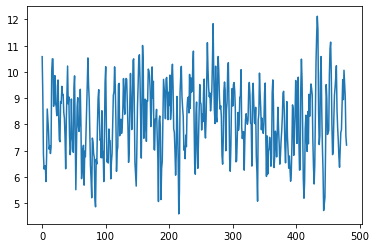

In [2]:
df1 = csvFile['Value']
X = df1.values
plt.plot(X)

ADF Statistic: -2.637600
p-value: 0.085472
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570
False


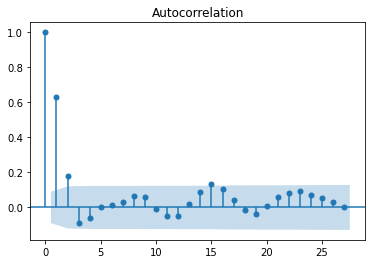

<Figure size 432x288 with 0 Axes>

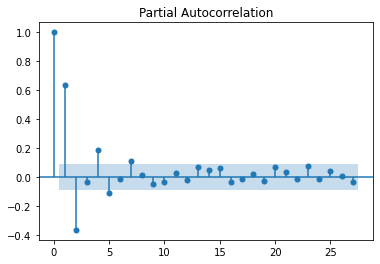

In [3]:
result = adfuller(df1, maxlag=52, autolag=None, regression='c')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

print(is_stationary(df1))
tsplot.plot_acf(X)
plt.figure()
tsplot.plot_pacf(X)    
plt.show()

In [4]:
res = sm.tsa.arma_order_select_ic(df1, ic=["aic", "bic"], trend="c")
print(res.aic_min_order)
print(res.bic_min_order)

(2, 2)
(0, 2)


In [9]:
trainRatio = .90
thresh = int(len(X)*trainRatio)
print(thresh)
X1 = df1[:thresh]
d = d_param(X1)
print('d=',d)
res = sm.tsa.arma_order_select_ic(X1, ic=["aic", "bic"], trend="c")
print(res.aic_min_order)
print(res.bic_min_order)

d = min([2,d])
print(d)

432
d= 25
(2, 2)
(0, 2)
2


In [6]:
p = 0
q = 2
print(p,d,q)

0 2 2


0 2 2
MSE: 1.2512397722556863
MAPE: 0.1077921622461094


Text(0, 0.5, 'Values')

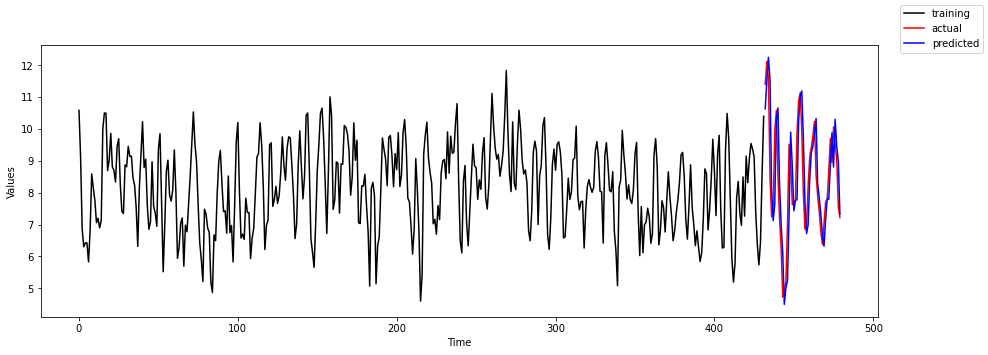

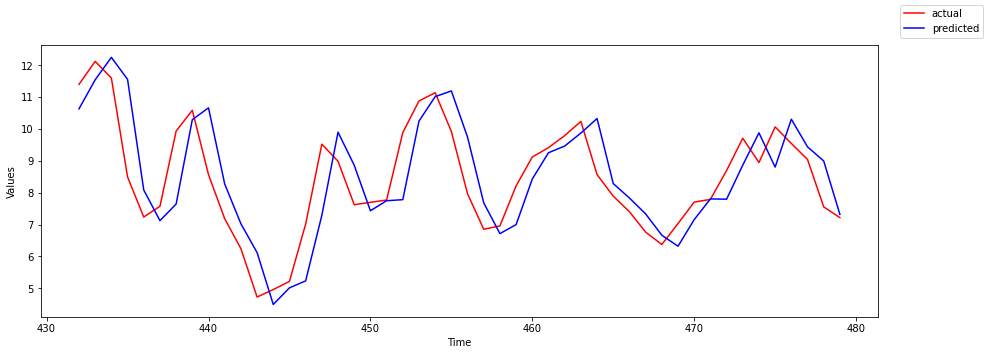

In [8]:

def evaluate_arima_model(X, arima_order, trainRatio):
    # prepare training dataset
    train_size = int(len(X)*trainRatio)
    train, test = X[:train_size], X[train_size:]

    history = [x for x in train]
    

    # make predictions
    predictions = []
    for i in range(0,len(test)):
        history1 = pd.DataFrame(np.asarray(history))

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]

        predictions.append(yhat)
        history.append(test[i])

    mse_error = mean_squared_error(test, predictions)
    mape_error = mean_absolute_percentage_error(test, predictions)

    return mse_error, mape_error, train, test, predictions

p = 0
q = 2
d = 2
print(p,d,q)

arima_order = (p,d,q)

mse_error, mape_error, train, test, predictions = evaluate_arima_model(df1.values, arima_order, trainRatio)
print('MSE:', mse_error)
print('MAPE:', mape_error)


trainRange = np.arange(0,len(train),1)
testRange = np.arange(len(train), len(train) + len(test),1)
# print(trainRange)
# print(testRange)
ax = plt.figure(figsize=(15,5))
plt.plot(trainRange, train, 'k')
plt.plot(testRange,test,'r')
plt.plot(testRange,predictions,'b')
ax.legend(['training', 'actual', 'predicted'])
plt.xlabel('Time')
plt.ylabel('Values')

ax1 = plt.figure(figsize=(15,5))
plt.plot(testRange,test,'r')
plt.plot(testRange,predictions,'b')
ax1.legend(['actual', 'predicted'])
plt.xlabel('Time')
plt.ylabel('Values')